In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import re
from skimage.filters import try_all_threshold, threshold_otsu
from skimage.restoration import denoise_wavelet
from osgeo import gdal
import rasterio
from rasterio.mask import mask
import geopandas as gpd

In [2]:
# load envelope images
directory = 'testing'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('optimal')]
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')
sorted_files = sorted(files, key=extract_number)
Y = []
for n, i in enumerate(sorted_files):
    temp = rasterio.open(i)
    Y.append(temp.read())
    temp.close()
    print(str(n+1)+"/"+str(len(sorted_files))+": "+sorted_files[n], end="\r")
Y = np.concatenate(Y)

In [3]:
# load original images
directory = 'testing'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('raster')]
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

sorted_files = sorted(files, key=extract_number)
X = []
for n, i in enumerate(sorted_files):
    temp = rasterio.open(i)
    X.append(temp.read())
    temp.close()
    print(str(n+1)+"/"+str(len(sorted_files))+": "+sorted_files[n], end="\r")
X = np.concatenate(X)

In [4]:
# delete temporary variable
del temp

# de-standardize data
std = np.std(X)
mean = np.mean(X)
Y_ = (Y * std) + mean

In [5]:
# ECS definition
def ECS(x, smooth_x=None):
    
    assert isinstance(x, np.ndarray), "'x' is not a numpy.ndarray"
    assert len(x.shape) == 3, "'x' is not three-dimensional"

    mean_image = x.mean(axis=0)
    
    if smooth_x is not None:
        assert isinstance(smooth_x, np.ndarray), "'smooth_x' is not a numpy.ndarray"
        assert len(smooth_x.shape) == 3, "'smooth_x' is not three-dimensional"
        assert x.shape == smooth_x.shape, "'x' and 'smooth_x' are different shapes"
        cube = smooth_x
    else:
        cube = x

    R = np.ndarray(mean_image.shape)
    D = np.ndarray(cube.shape)

    dims = mean_image.shape
    
    lin = dims[0]
    col = dims[1]
    
    for i in range(0, cube.shape[0]):
        D[i] = (cube[i] - mean_image)**2
    
    d = D.sum(axis=(1, 2)).ravel()

    for i in range(lin):
        for j in range(col):
            R[i, j] = np.abs(np.corrcoef(d, D[:, i, j])[0][1])
    
    return R

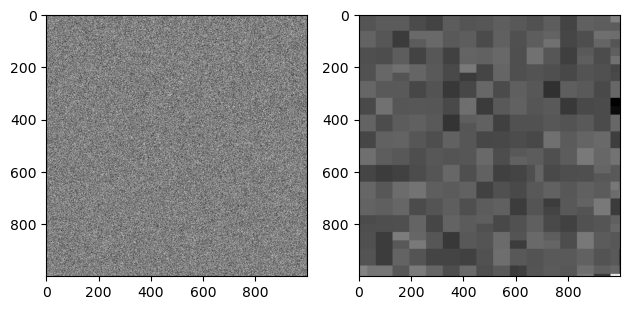

In [6]:
# wavelet visu
noise = np.random.random((1000,1000))
wav = denoise_wavelet(noise, rescale_sigma=False, wavelet="haar")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(noise, cmap="gray")
ax[1].imshow(wav, cmap="gray")
plt.tight_layout()
plt.show()